# **<u>Options Pricing & Greeks Calculator (Black Scholes + Monte Carlo)</u>**
This projects prices European options under the Black-Scholes assumptions and comparing analytical pricing and Greeks with Monte Carlo estimates.

# **1. Loading Libraries**


In [7]:
import numpy as np
import scipy.stats as si
import matplotlib as plt
import math
import pandas as pd
import time

# **2. Mathematical Framework (Black Scholes Options Pricing)**
Ther exist 2 types of options in financial markets:


*  **Call Option**: Gives One the right (no obligation) to buy an financial asset at afixed price 𝐾
*   **Put Option**: gives you the right to sell a financial asset at a price 𝐾

The Black-Scholes model is a widely recognized mathematical framework to estimate the options' fair price.


**Assumptions under the Black-Scholes model:**


*   European exercise only (Exercion at expiry time 𝑇)
*   log returns $ln(\frac{P_(t+1)}{P_t})$ are normaly distributed, thus volatility is constant
*   Constant risk free rate 𝑟
*   Prices move randomly





**Introductions of variables:**


*   $𝑆_0$: Spot Price (Current price of the stock)
*   𝐾: Strike Price (Agreed buy/sell price)
*   𝑇: Time to expiry [years]
*   𝑟: Risk-Free Rate (interest rate) = const.
*   σ: Volatility (Standard deviation of log returns) = const.


<u>**Black-Scholes Equations** </u>

$\underline{\underline{𝐶 = 𝑆_0𝑁(𝑑_1) - 𝑁(𝑑_2)𝐾𝑒^{-𝑟𝑇}}}$

with:

$𝑑_1$ = $\frac{ln(\frac{S_0}{K}) + (r + \frac{σ^2}{2})T}{σ\sqrt{T}}$ &

$d_2 = d_1 - σ\sqrt{T}$

where $N(.)$ represents the CDF of the normal distribution with μ = 1 and the standard deviation of the distribution is given by σ = 1, not to be mistaken for the volatility. So $N(x) = 𝚽(x) = ∫_{-∞}^{x}\frac{1}{\sqrt(2π)}e^{\frac{1}{2}x^{2}} = P(X < x)$

$d_1, d_2$ are temporary variables. $N(d_1)$ describes a probability the option ends in the money and $N(d_2)$ essentially describes the same but is adjusted for discounting

Call Put Pairity is given by the following:

$C - P = S_0 - e^{-rT} ⇒ P = C - S + Ke^{-rT}$

$P = SN(d_1) - N(d_2)Ke^{-rT} - S_0 + Ke{-rT}$

$ P = S_0 [N(d_1) - 1] + Ke^{-rT}[1 - N(d_2)]$

Since the distribution function is an even function and the area under the curve  is 1

$1 - N(x) = N(-x)$

$\underline{\underline{⇒ P = Ke^{-rT}N(-d_2) - SN(-d_1)}}$

<u>Problemtaic Edge Cases</u>

Notice how volatility σ and time to expiry $T$ are in the denominator of the formulas for $d_1$ and $d_2$. This makes them undefined for 0 volatility and immediate payoff.


*   Zero volatility (σ = 0)
    
    The stock has no randomness, the future price is known with certainty.
    Stock price at time T can be modelled by

    $S_T = S_0e^{rT}$
*   Call and Put option can then be computed by:

$\boxed{C = max(0, S_0 - Ke^{-rT})}$ &
$\boxed{P = max(0, Ke^{-rT} - S_0)}$



# **3. Implementing Black Scholes Pricing**

In [8]:
##Black-Scholes Pricing Function
def black_scholes_price(S, K, T, r, sigma, optionType = "call"):
  #Check valid market inputs
  if optionType not in ["call", "put"]:
    raise ValueError("Option type must be either 'call' or 'put'.")
  if sigma <= 0:
    raise ValueError("Volatility (sigma) must be greater than zero.")
  if T < 0:
    raise ValueError("Time to expiry (T) must be greater than zero.")
  if S < 0:
    raise ValueError("Spot price (S) must be greater than zero.")
  if K < 0:
    raise ValueError("Strike price (K) must be greater than zero.")

  #immediate payoff (T = 0)
  if T <= 1e-8:
    if optionType == "call":
      return max(0, S - K)
    else:
      return max(0, K - S)

  #Zero volatility (sigma = 0)
  if sigma == 1e-8:
    if optionType == "call":
      return max(0, S - K * math.exp(-r * T))
    else:
      return max(0, K * math.exp(-r * T) - S)
  #Compute d_1:
  d_1 = (math.log(S/K) + (r + sigma ** 2 / 2) * T) / (sigma * math.sqrt(T))
  #Compute d_2:
  d_2 = d_1 - sigma * math.sqrt(T)

  # Define Normal CDF function with mu = 0, sigma = 1
  N = lambda x: si.norm.cdf(x, 0.0, 1.0)

  # return call and put option
  if optionType == "call":
    call = S * N(d_1) - N(d_2) * K * math.exp(-r * T)
    return call
  else:
    put = K * math.exp(-r * T) * N(-d_2) - S * N(-d_1)
    return put

3.1. **<u>Testing</u>**:

In [9]:
##Test some values
S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
call = black_scholes_price(S, K, T, r, sigma)
put = black_scholes_price(S, K, T, r, sigma, optionType = "put")
print( "Call = ", call)
print( "Put = ", put)
#put-call-pairity
print("Pairity Testing")
print(call - put)
print(S - K * math.exp(-r * T)) ## Check, whether both statements evaluate to the same

Call =  10.450583572185572
Put =  5.573526022256971
Pairity Testing
4.877057549928601
4.877057549928594


In [10]:
#ATM (At the money)
S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
call_atm = black_scholes_price(S, K, T, r, sigma)
put_atm = black_scholes_price(S, K, T, r, sigma, optionType = "put")
print("Call ATM= ", call_atm)
print("Put ATM= ", put_atm)
#put cal pairity
print("Pairity Testing")
print(call - put)
print(S - K * math.exp(-r * T)) ## Check, whether both statements evaluate to the same

Call ATM=  10.450583572185572
Put ATM=  5.573526022256971
Pairity Testing
4.877057549928601
4.877057549928594


In [11]:
##ITM (In the money) call /OTM (on the money) Put
S, K, T, r, sigma = 120, 100, 1.0, 0.05, 0.2
call_itm = black_scholes_price(S, K, T, r, sigma)
put_otm = black_scholes_price(S, K, T, r, sigma, optionType = "put")
print("Call ITM = ", call_itm)
print("Put OTM= ", put_otm)
#call should approx. equal S_Kexp(-rT)
print(S - K * math.exp(-r * T))

Call ITM =  26.169043946847296
Put OTM=  1.2919863969187073
24.877057549928594


In [12]:
##OTM Call/ ITM Put
S, K, T, r, sigma = 80, 100, 1.0, 0.05, 0.2
call_otm = black_scholes_price(S, K, T, r, sigma)
put_itm = black_scholes_price(S, K, T, r, sigma, optionType = "put")
print("Call OTM = ", call_otm)
print("Put ITM= ", put_itm)
#put should approx. equal to Kexp(-rT) - S
print(K * math.exp(-r * T) - S)

Call OTM =  1.8594195728121843
Put ITM=  16.982362022883592
15.122942450071406


3.2. **<u>Visualization of dependencies</u>**:

Visualizing Options Price vs
1.  Spot Price (S), keeping strike price (K=100), time to expiry (T=1.0), risk-free rate (r=0.05), and volatility (sigma=0.2) constant.
2.  Volatility (sigma), keeping spot price (S=100), strike price (K=100), time to expiry (T=1.0), and risk-free rate (r=0.05) constant.
3.  Time to Expiry (T), keeping spot price (S=100), strike price (K=100), risk-free rate (r=0.05), and volatility (sigma=0.2) constant.
Ensure each plot has appropriate labels, titles, and a legend.

Generate Data

In [13]:
## OP vs S
S_range = np.linspace(50, 150, 101) # Range of spot prices from 50 to 150
K = 100
T = 1.0
r = 0.05
sigma = 0.2

call_prices = []
put_prices = []

for S_val in S_range:
    call_price = black_scholes_price(S_val, K, T, r, sigma, optionType="call")
    put_price = black_scholes_price(S_val, K, T, r, sigma, optionType="put")
    call_prices.append(call_price)
    put_prices.append(put_price)

option_prices_df = pd.DataFrame({
    'Spot Price': S_range,
    'Call Price': call_prices,
    'Put Price': put_prices
})

print("Generated DataFrame for Option Prices vs Spot Price:")
print(option_prices_df.head())
print(option_prices_df.tail())

Generated DataFrame for Option Prices vs Spot Price:
   Spot Price  Call Price  Put Price
0        50.0    0.002399  45.125342
1        51.0    0.003488  44.126431
2        52.0    0.004993  43.127935
3        53.0    0.007040  42.129983
4        54.0    0.009787  41.132730
     Spot Price  Call Price  Put Price
96        146.0   51.012105   0.135047
97        147.0   52.000168   0.123110
98        148.0   52.989249   0.112191
99        149.0   53.979265   0.102207
100       150.0   54.970140   0.093083


In [14]:
## OP vs sigma
sigma_range = np.linspace(0.01, 1.0, 100) # Range of volatility from 0.01 to 1.0
S = 100
K = 100
T = 1.0
r = 0.05

call_prices_sigma = []
put_prices_sigma = []

for sigma_val in sigma_range:
    call_price_sigma = black_scholes_price(S, K, T, r, sigma_val, optionType="call")
    put_price_sigma = black_scholes_price(S, K, T, r, sigma_val, optionType="put")
    call_prices_sigma.append(call_price_sigma)
    put_prices_sigma.append(put_price_sigma)

option_prices_sigma_df = pd.DataFrame({
    'Volatility': sigma_range,
    'Call Price': call_prices_sigma,
    'Put Price': put_prices_sigma
})

print("Generated DataFrame for Option Prices vs Volatility:")
print(option_prices_sigma_df.head())
print(option_prices_sigma_df.tail())

Generated DataFrame for Option Prices vs Volatility:
   Volatility  Call Price     Put Price
0        0.01    4.877058  5.214107e-08
1        0.02    4.880967  3.909147e-03
2        0.03    4.935064  5.800623e-02
3        0.04    5.074382  1.973246e-01
4        0.05    5.283269  4.062114e-01
    Volatility  Call Price  Put Price
95        0.96   38.461669  33.584612
96        0.97   38.807542  33.930484
97        0.98   39.152586  34.275529
98        0.99   39.496795  34.619738
99        1.00   39.840162  34.963105


In [15]:
## OP vs T
T_range = np.linspace(0.01, 2.0, 100) # Range of time to expiry from 0.01 to 2.0 years
S = 100
K = 100
r = 0.05
sigma = 0.2

call_prices_T = []
put_prices_T = []

for T_val in T_range:
    call_price_T = black_scholes_price(S, K, T_val, r, sigma, optionType="call")
    put_price_T = black_scholes_price(S, K, T_val, r, sigma, optionType="put")
    call_prices_T.append(call_price_T)
    put_prices_T.append(put_price_T)

option_prices_T_df = pd.DataFrame({
    'Time to Expiry': T_range,
    'Call Price': call_prices_T,
    'Put Price': put_prices_T
})

print("Generated DataFrame for Option Prices vs Time to Expiry:")
print(option_prices_T_df.head())
print(option_prices_T_df.tail())

Generated DataFrame for Option Prices vs Time to Expiry:
   Time to Expiry  Call Price  Put Price
0        0.010000    0.822915   0.772927
1        0.030101    1.459688   1.309296
2        0.050202    1.913482   1.662787
3        0.070303    2.291695   1.940797
4        0.090404    2.625506   2.174506
    Time to Expiry  Call Price  Put Price
95        1.919596   15.710996   6.559233
96        1.939697   15.815451   6.572427
97        1.959798   15.919564   6.585370
98        1.979899   16.023339   6.598067
99        2.000000   16.126780   6.610522


Create Plots

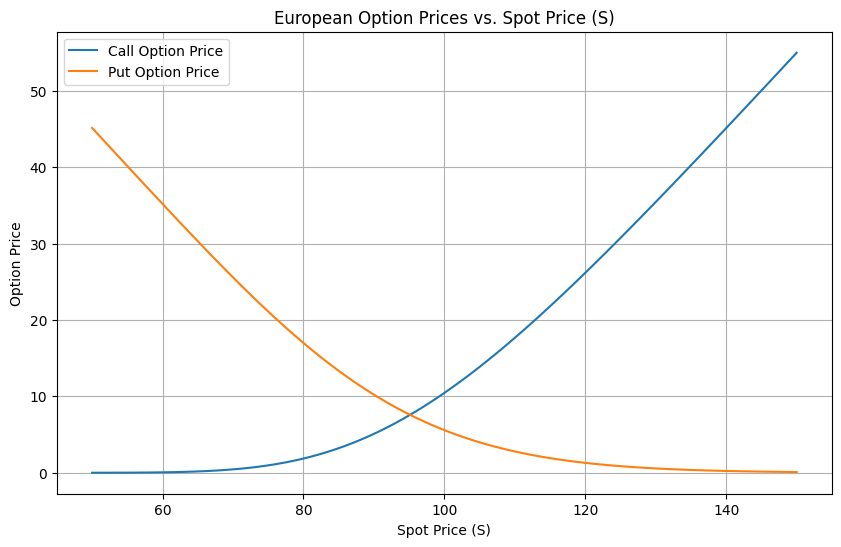

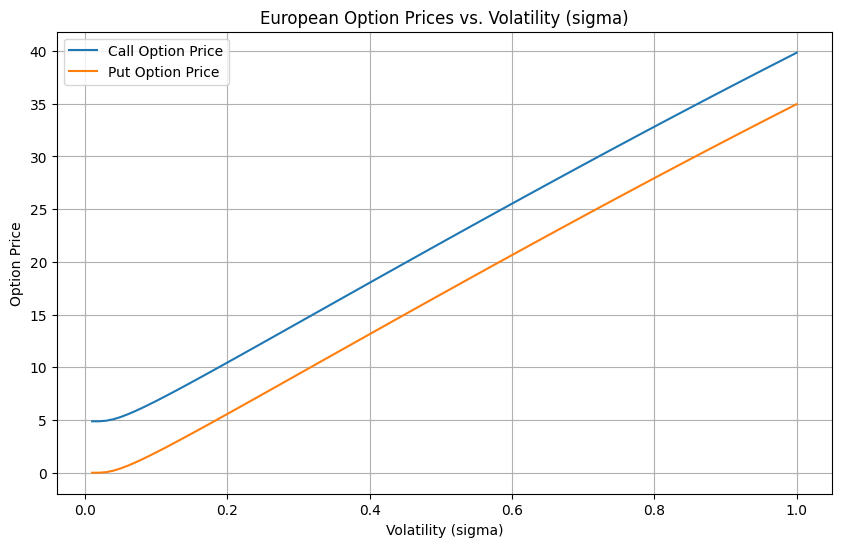

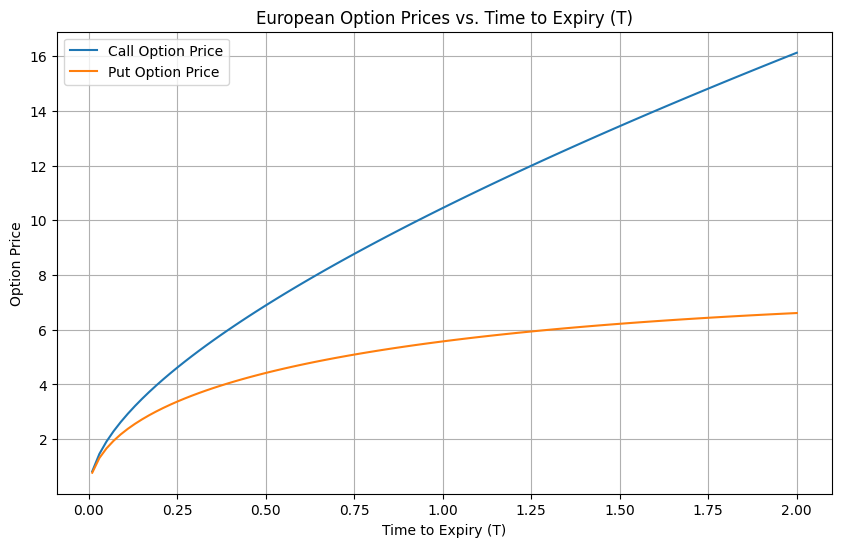

In [16]:
import matplotlib.pyplot as plt

# Plot 1: Option Price vs Spot Price (S)
plt.figure(figsize=(10, 6))
plt.plot(option_prices_df['Spot Price'], option_prices_df['Call Price'], label='Call Option Price')
plt.plot(option_prices_df['Spot Price'], option_prices_df['Put Price'], label='Put Option Price')
plt.title('European Option Prices vs. Spot Price (S)')
plt.xlabel('Spot Price (S)')
plt.ylabel('Option Price')
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Option Price vs Volatility (sigma)
plt.figure(figsize=(10, 6))
plt.plot(option_prices_sigma_df['Volatility'], option_prices_sigma_df['Call Price'], label='Call Option Price')
plt.plot(option_prices_sigma_df['Volatility'], option_prices_sigma_df['Put Price'], label='Put Option Price')
plt.title('European Option Prices vs. Volatility (sigma)')
plt.xlabel('Volatility (sigma)')
plt.ylabel('Option Price')
plt.grid(True)
plt.legend()
plt.show()

# Plot 3: Option Price vs Time to Expiry (T)
plt.figure(figsize=(10, 6))
plt.plot(option_prices_T_df['Time to Expiry'], option_prices_T_df['Call Price'], label='Call Option Price')
plt.plot(option_prices_T_df['Time to Expiry'], option_prices_T_df['Put Price'], label='Put Option Price')
plt.title('European Option Prices vs. Time to Expiry (T)')
plt.xlabel('Time to Expiry (T)')
plt.ylabel('Option Price')
plt.grid(True)
plt.legend()
plt.show()

**<u>Summary:</u>**

**Data Analysis Key Findings:**

*   **Impact of Spot Price (S) on Option Prices:**
    *   As the spot price increases from \$50 to \$150, European call option prices increase significantly (e.g., from approximately \$0.0024 at S=\$50 to \$54.9701 at S=\$150).
    *   Conversely, European put option prices decrease significantly with increasing spot price (e.g., from approximately \$45.1253 at S=\$50 to \$0.0931 at S=\$150).
    *   Call options show a positive correlation with spot price, while put options show a negative correlation.
*   **Impact of Volatility (sigma) on Option Prices:**
    *   Both European call and put option prices consistently increase with increasing volatility across the range from 0.01 to 1.0.
    *   This indicates that higher volatility leads to higher option premiums for both types of options, as it implies a greater chance of significant price movements.
*   **Impact of Time to Expiry (T) on Option Prices:**
    *   Both European call and put option prices generally increase with increasing time to expiry, from 0.01 to 2.0 years.
    *   This reflects the "time value" of options, where more time allows for a greater probability of the underlying asset price moving favorably for the option holder.  

*   The Black-Scholes model demonstrates that European call options benefit from higher spot prices, volatility, and time to expiry, whereas put options benefit from lower spot prices but also higher volatility and time to expiry.
*   Further analysis could involve exploring the impact of the risk-free rate (r) and strike price (K) on option prices, or examining implied volatility from market prices.


# **4. Option Greeks: Sensitivity Analysis**



*   Greeks measure first- and second order sensitivities
*   They are fundamental for hedging and risk management



4.1. <u>Delta δ:</u>



*   The Call Delta describes, how much the option price changes if the stock goes up by 1
*   Put Delta essentially decribes the same, just negative

    Delta is the exposure to the underlying asset.

    Example:


*   δ = 1 ⇒ almost like holding the stock
*   δ = 0.5 ⇒ option behaves like half a share
*   δ = 0 ⇒ essentially worthless option

So what δ essentially tells us, is the rate of change of the option with respect to the Spot Price $S_0$

**General formula for Delta:**
$\boxed{δ = \frac{\partial V}{\partial S_0}}$

Remember our formulas for Call and Put Option:

$C = S_0N(d_1) - N(d_2)Ke^{-rT}$;   

$P = N(-d_2)Ke^{-rT} - S_0N(-d_1)$

Call Delta:

⇒ $\delta_C = \frac{\partial C}{\partial S_0}$

⇒ $\delta_C = \frac{\partial}{\partial S_0}(SN(d_1) - N(d_2)Ke^{-rT})$

$\boxed{\delta_C =  N(d_1)}$

Put Delta:

⇒ $\delta_P = \frac{\partial P}{\partial S_0}$

⇒ $\delta_P = \frac{\partial}{\partial S_0}(N(-d_2)Ke^{-rT} - S_0N(-d_1)) = - N(-d_1)$

$\boxed{\delta_P =  N(d_1) - 1}$


At expiry or zero volatility, option prices become piecewise linear functions of the underlying, leading to discontinuous Delta behavior. In these cases, limiting analytical values were used to ensure numerical stability



In [17]:
##Implementing Delta
def bs_delta(S, K, T, r, sigma, optionType = "call"):
  if optionType not in ["call", "put"]:
    raise ValueError("Option type must be either 'call' or 'put'.")

  # Minimal Numerical Tolerance
  eps = 1e-8

  # Maturity Case (T = 0)
  if T <= eps:
    if optionType == "call":
      if S > K:
        return 1.0
      elif S < K:
        return 0.0
      else:
        return 0.5 #ATM Convention
    else: # Put Option
      if S < K:
        return -1.0
      elif S > K:
        return 0.0
      else:
        return 0.5 #ATM Convention

  # Zero volatility case
  if sigma <= eps:
    forward_price = S * math.exp(r * T)
    if optionType == "call":
      return 1.0 if forward_price > K else 0.0
    else: # Put Option
      return -1.0 if forward_price < K else 0.0

  # define Normal CDF with mu = 0, sigma = 1
  N = lambda x: si.norm.cdf(x, 0.0, 1.0)

  #Compute d_1:
  d_1 = (math.log(S/K) + (r + sigma ** 2 / 2) * T) / (sigma * math.sqrt(T))

  #Compute delta for options:
  if optionType == "call":
    delta_C = N(d_1)
    return delta_C
  else:
    delta_P = N(d_1) - 1
    return delta_P

**<u>4.1.1. Testing Delta</u>:**

In [18]:
## ATM (At the money)
S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
delta_C_atm = bs_delta(S, K , T, r, sigma)
delta_P_atm = bs_delta(S, K , T, r, sigma, optionType = "put")
print("Delta Call ATM= ", delta_C_atm)
print("Delta Put ATM= ", delta_P_atm)

Delta Call ATM=  0.6368306511756191
Delta Put ATM=  -0.3631693488243809


In [19]:
## ITM Call/ OTM Put:
S, K, T, r, sigma = 150, 100, 1.0, 0.05, 0.2
delta_C_itm = bs_delta(S, K , T, r, sigma)
delta_P_otm = bs_delta(S, K , T, r, sigma, optionType = "put")
print("Delta Call ITM = ", delta_C_itm)
print("Delta Put OTM= ", delta_P_otm)


Delta Call ITM =  0.9912806549873657
Delta Put OTM=  -0.008719345012634272


In [20]:
## OTM Call / ITM Put
S, K, T, r, sigma = 50, 100, 1.0, 0.05, 0.2
delta_C_otm = bs_delta(S, K , T, r, sigma)
delta_P_itm = bs_delta(S, K, T, r, sigma, optionType = "put")
print("Delta Call OTM = ", delta_C_otm)
print("Delta Put ITM = ", delta_P_itm)

Delta Call OTM =  0.0009174326039451515
Delta Put ITM =  -0.9990825673960548


In [21]:
## Expire Test
S_1, K_1, T_1, r_1, sigma_1 = 150, 100, 0.0, 0.05, 0.2
S_2, K_2, T_2, r_2, sigma_2 = 50, 100, 0.0, 0.05, 0.2
S_3, K_3, T_3, r_3, sigma_3 = 50, 50, 0.0, 0.05, 0.2
# S > K:
delta_C1 = bs_delta(S_1, K_1, T_1, r_1, sigma_1)
delta_P1 = bs_delta(S_1, K_1, T_1, r_1, sigma_1, optionType = "put")
print("Delta Call Expire = ", delta_C1)
print("Delta Put Expire = ", delta_P1)
# S < K:
delta_C2 = bs_delta(S_2, K_2, T_2, r_2, sigma_2)
delta_P2 = bs_delta(S_2, K_2, T_2, r_2, sigma_2, optionType = "put")
print("Delta Call Expire = ", delta_C2)
print("Delta Put Expire = ", delta_P2)
# S = K:
delta_C3 = bs_delta(S_3, K_3, T_3, r_3, sigma_3)
delta_P3 = bs_delta(S_3, K_3, T_3, r_3, sigma_3, optionType = "put")
print("Delta Call Expire = ", delta_C3)
print("Delta Put Expire = ", delta_P3)

Delta Call Expire =  1.0
Delta Put Expire =  0.0
Delta Call Expire =  0.0
Delta Put Expire =  -1.0
Delta Call Expire =  0.5
Delta Put Expire =  0.5


In [22]:
## Zero Volatility Tests
# Case Se^(rT) > K:
S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.0
delta_C1 = bs_delta(S, K, T, r, sigma)
delta_P1 = bs_delta(S, K, T, r, sigma, optionType = "put")
print("For Case Se^(rT) > K:")
print("Delta Call = ", delta_C1)
print("Delta Put = ", delta_P1)
# Case Se^(rT) < K:
S, K, T, r, sigma = 90, 100, 1.0, 0.05, 0.0
delta_C2 = bs_delta(S, K, T, r, sigma)
delta_P2 = bs_delta(S, K, T, r, sigma, optionType = "put")
print("For Case Se^(rT) < K:")
print("Delta Call = ", delta_C2)
print("Delta Put = ", delta_P2)

For Case Se^(rT) > K:
Delta Call =  1.0
Delta Put =  0.0
For Case Se^(rT) < K:
Delta Call =  0.0
Delta Put =  -1.0


In [23]:
S_range = np.linspace(50, 150, 101) # Range of spot prices from 50 to 150
K = 100
T = 1.0
r = 0.05
sigma = 0.2

call_deltas = []
put_deltas = []

for S_val in S_range:
    call_delta = bs_delta(S_val, K, T, r, sigma, optionType="call")
    put_delta = bs_delta(S_val, K, T, r, sigma, optionType="put")
    call_deltas.append(call_delta)
    put_deltas.append(put_delta)

delta_df = pd.DataFrame({
    'Spot Price': S_range,
    'Call Delta': call_deltas,
    'Put Delta': put_deltas
})

print("Generated DataFrame for Option Deltas vs Spot Price:")
display(delta_df.head())
display(delta_df.tail())

Generated DataFrame for Option Deltas vs Spot Price:


,Spot Price,Call Delta,Put Delta
0,50.0,0.000917,-0.999083
1,51.0,0.001278,-0.998722
2,52.0,0.001752,-0.998248
3,53.0,0.002369,-0.997631
4,54.0,0.003158,-0.996842


,Spot Price,Call Delta,Put Delta
96,146.0,0.987525,-0.012475
97,147.0,0.988586,-0.011414
98,148.0,0.989562,-0.010438
99,149.0,0.990458,-0.009542
100,150.0,0.991281,-0.008719


**<u>4.1.2. Plotting Call and Put Delta vs Spot Price</u>**




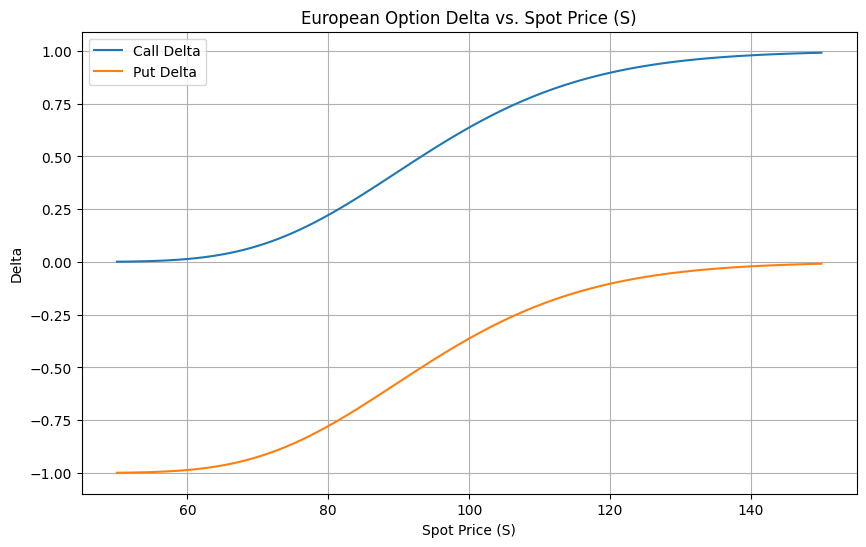

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(delta_df['Spot Price'], delta_df['Call Delta'], label='Call Delta')
plt.plot(delta_df['Spot Price'], delta_df['Put Delta'], label='Put Delta')
plt.title('European Option Delta vs. Spot Price (S)')
plt.xlabel('Spot Price (S)')
plt.ylabel('Delta')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
## Immeadiate Expiry (T = 0)
S_range = np.linspace(50, 150, 101) # Range of spot prices from 50 to 150
K = 100
T_zero = 1e-8 # Approximately zero time to expiry
r = 0.05
sigma = 0.2

call_deltas_T_zero = []
put_deltas_T_zero = []

for S_val in S_range:
    call_delta = bs_delta(S_val, K, T_zero, r, sigma, optionType="call")
    put_delta = bs_delta(S_val, K, T_zero, r, sigma, optionType="put")
    call_deltas_T_zero.append(call_delta)
    put_deltas_T_zero.append(put_delta)

delta_df_T_zero = pd.DataFrame({
    'Spot Price': S_range,
    'Call Delta': call_deltas_T_zero,
    'Put Delta': put_deltas_T_zero
})

print("Generated DataFrame for Option Deltas vs Spot Price (T=0):")
display(delta_df_T_zero.head())
display(delta_df_T_zero.tail())

Generated DataFrame for Option Deltas vs Spot Price (T=0):


,Spot Price,Call Delta,Put Delta
0,50.0,0.0,-1.0
1,51.0,0.0,-1.0
2,52.0,0.0,-1.0
3,53.0,0.0,-1.0
4,54.0,0.0,-1.0


,Spot Price,Call Delta,Put Delta
96,146.0,1.0,0.0
97,147.0,1.0,0.0
98,148.0,1.0,0.0
99,149.0,1.0,0.0
100,150.0,1.0,0.0


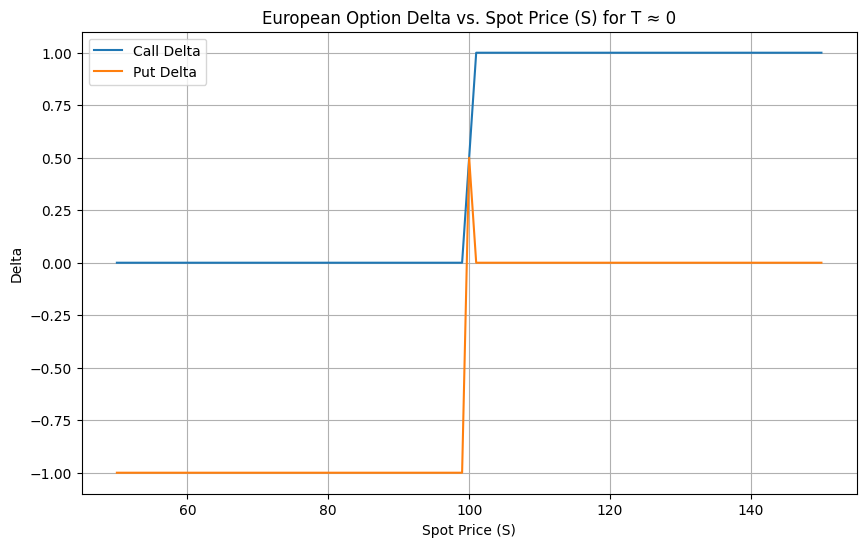

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(delta_df_T_zero['Spot Price'], delta_df_T_zero['Call Delta'], label='Call Delta')
plt.plot(delta_df_T_zero['Spot Price'], delta_df_T_zero['Put Delta'], label='Put Delta')
plt.title('European Option Delta vs. Spot Price (S) for T \u2248 0')
plt.xlabel('Spot Price (S)')
plt.ylabel('Delta')
plt.grid(True)
plt.legend()
plt.show()

In [27]:
## Zero volatility
S_range = np.linspace(50, 150, 101) # Range of spot prices from 50 to 150
K = 100
T = 1.0
r = 0.05
sigma_zero = 1e-8 # Approximately zero volatility

call_deltas_sigma_zero = []
put_deltas_sigma_zero = []

for S_val in S_range:
    call_delta = bs_delta(S_val, K, T, r, sigma_zero, optionType="call")
    put_delta = bs_delta(S_val, K, T, r, sigma_zero, optionType="put")
    call_deltas_sigma_zero.append(call_delta)
    put_deltas_sigma_zero.append(put_delta)

delta_df_sigma_zero = pd.DataFrame({
    'Spot Price': S_range,
    'Call Delta': call_deltas_sigma_zero,
    'Put Delta': put_deltas_sigma_zero
})

print("Generated DataFrame for Option Deltas vs Spot Price (sigma=0):")
display(delta_df_sigma_zero.head())
display(delta_df_sigma_zero.tail())

Generated DataFrame for Option Deltas vs Spot Price (sigma=0):


,Spot Price,Call Delta,Put Delta
0,50.0,0.0,-1.0
1,51.0,0.0,-1.0
2,52.0,0.0,-1.0
3,53.0,0.0,-1.0
4,54.0,0.0,-1.0


,Spot Price,Call Delta,Put Delta
96,146.0,1.0,0.0
97,147.0,1.0,0.0
98,148.0,1.0,0.0
99,149.0,1.0,0.0
100,150.0,1.0,0.0


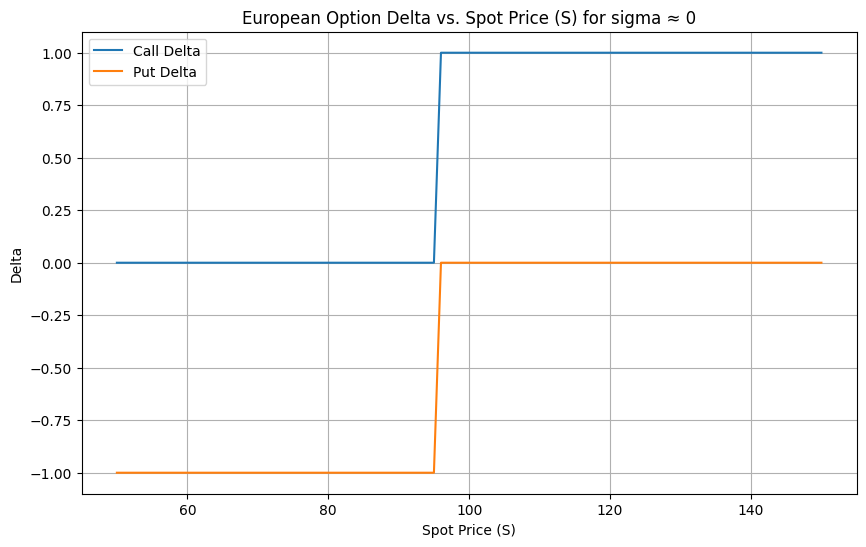

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(delta_df_sigma_zero['Spot Price'], delta_df_sigma_zero['Call Delta'], label='Call Delta')
plt.plot(delta_df_sigma_zero['Spot Price'], delta_df_sigma_zero['Put Delta'], label='Put Delta')
plt.title('European Option Delta vs. Spot Price (S) for sigma \u2248 0')
plt.xlabel('Spot Price (S)')
plt.ylabel('Delta')
plt.grid(True)
plt.legend()
plt.show()

**<u>4.2. Gamma</u>**

Gamma measures how fast Delta changes as the underlying price changes. It captures curvature of the Option Price.
High Gamma ⇒ Delta is unstable ⇒ hedging is hard

**Mathematical Definition**: $\boxed{ℾ = \frac{\partial^2V}{\partial S_0^2$}$

Applying this to our Black-Scholes Equations we get:

$ℾ = \frac{\partial}{\partial S_0}(δ_C) = \frac{\partial}{\partial S_0}(N(d_1)) = \frac{\partial d_1}{\partial S_0}\frac{\partial N}{\partial d_1}$

Note: $\frac{\partial N}{\partial d_1} = n(d_1)$ where n(x) describes the pdf of the normal dirtribution with μ = 0 and σ = 1 $(n(x) = \frac{1}{\sqrt(2\pi)}e^{-\frac{1}{2}x^2})$

$⇒ \frac{\partial d_1}{\partial S_0} = \frac{\partial}{\partial S_0} (\frac{ln(\frac{S_0}{K}) + (r + \frac{σ^2}{2})T}{σ\sqrt{T}}) = \frac{1}{σ\sqrt(T)}$
  
$\boxed{⇒ ℾ = \frac{n(d_1)}{Sσ\sqrt(T)}}$

Gamma is mathematically the same for Call and Put Option. Gamma reaches it maximum ATM

In [29]:
## Implementing Gamma
def bs_gamma(S, K, T, r, sigma):
  # define normal pdf
  n = lambda x: si.norm.pdf(x)
  #define d1:
  d1 = (math.log(S/K) + (r + sigma ** 2 / 2) * T) / (sigma * math.sqrt(T))
  gamma = n(d1) / (S * sigma * math.sqrt(T))
  return gamma

**<u>4.2.1. Testing Gamma:</u>**

In [30]:
## Non-negativity sanity check #ATM
S, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
gamma_ATM = bs_gamma(S, K, T, r, sigma)
print("Gamma = ", gamma_ATM)

Gamma =  0.018762017345846895


In [31]:
## OTM
S, K, T, r, sigma = 80, 100, 1, 0.05, 0.2
gamma_OTM = bs_gamma(S, K, T, r, sigma)
print("Gamma = ", gamma_OTM)

Gamma =  0.018598225671687875


In [32]:
## ITM
S, K, T, r, sigma = 120, 100, 1, 0.05, 0.2
gamma_ITM = bs_gamma(S, K, T, r, sigma)
print("Gamma = ", gamma_ITM) # Note: Gamma(S = 100) > Gamma(S = 80); Gamma(S = 100) > Gamma(S = 120)

Gamma =  0.007500245963538315


In [33]:
## Deep ITM / OTM Decay
S_1, S_2, K, T, r, sigma = 20, 300, 100, 1, 0.05, 0.2
gamma_deepITM = bs_gamma(S_2, K, T, r, sigma)
gamma_deepOTM = bs_gamma(S_1, K, T, r, sigma)
print("Gamma Deep ITM = ", gamma_deepITM) # Approaching 0
print("Gamma Deep OTM = ", gamma_deepOTM) # Approaching 0

Gamma Deep ITM =  2.564809788100988e-10
Gamma Deep OTM =  1.3601497848449089e-14


In [34]:
## Time to maturity behaviour
# Gamma is proportional to 1/sqrt(T)
S, K, T_1, T_2, T_3, r, sigma = 100, 100, 1, 0.1, 0.01, 0.05, 0.2
gamma_T_1 = bs_gamma(S, K, T_1, r, sigma)
gamma_T_2 = bs_gamma(S, K, T_2, r, sigma)
gamma_T_3 = bs_gamma(S, K, T_3, r, sigma)
print("Gamma T_1 = ", gamma_T_1)
print("Gamma T_2 = ", gamma_T_2)
print("Gamma T_3 = ", gamma_T_3) # Note: Gamma(T = 0.01) > Gamma(T = 0.1) > Gamma(T = 1)

Gamma T_1 =  0.018762017345846895
Gamma T_2 =  0.06269313918221042
Gamma T_3 =  0.19934900153612786


 <u>**4.2.2 Plotting Gamma:**</u>

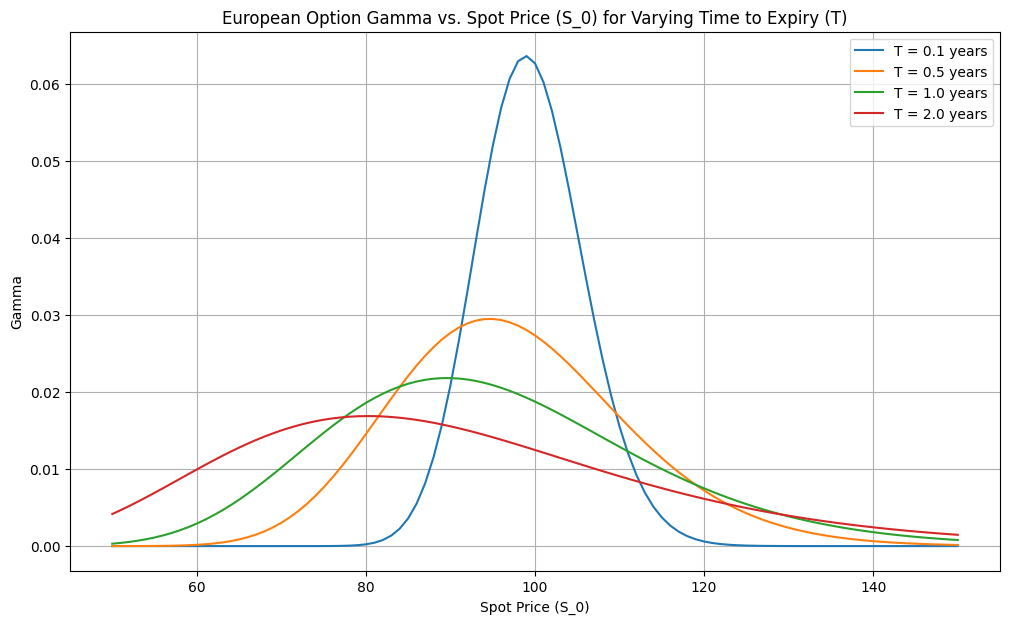

In [35]:
## Plot Gamma vs S with varying T
# Define common parameters
K = 100
r = 0.05
sigma = 0.2
S_range = np.linspace(50, 150, 101) # Range of spot prices

# Define different Time to Expiry values to compare
T_values = [0.1, 0.5, 1.0, 2.0] # Short, Medium, Long-term expiries

plt.figure(figsize=(12, 7))

for T_val in T_values:
    gamma_values = []
    for S_val in S_range:
        gamma_values.append(bs_gamma(S_val, K, T_val, r, sigma))
    plt.plot(S_range, gamma_values, label=f'T = {T_val} years')

plt.title('European Option Gamma vs. Spot Price (S_0) for Varying Time to Expiry (T)')
plt.xlabel('Spot Price (S_0)')
plt.ylabel('Gamma')
plt.grid(True)
plt.legend()
plt.show()

<u>**4.2.3. Numerical Validation:**</u>

Numerically ℾ can be approximated by:
$ℾ = \frac{δ(S_0 + h) - \delta(S_0 - h)}{2h}$

In [36]:
gamma_analytical = bs_gamma(S, K, T, r, sigma)
def gamma_numerical(S, K, T, r, sigma, h):
  gamma_numerical = (bs_delta(S + h, K, T, r, sigma) - bs_delta(S - h, K, T, r, sigma)) / (2 * h)
  return gamma_numerical

In [37]:
S, K, T, r, sigma = 120, 100, 1, 0.05, 0.2
print("Analytical Gamma = ", gamma_analytical)
print("Numerical Gamma_1 = ", gamma_numerical(S, K, T, r, sigma, 1))
print("Numerical Gamma_2 = ", gamma_numerical(S, K, T, r, sigma, 0.1))
print("Numerical Gamma_3 = ", gamma_numerical(S, K, T, r, sigma, 0.01))
print("Numerical Gamma_4 = ", gamma_numerical(S, K, T, r, sigma, 0.001))
# Notice, how numerical value converges to analytical value as h approaches 0

Analytical Gamma =  0.018762017345846895
Numerical Gamma_1 =  0.007503345198781208
Numerical Gamma_2 =  0.007500276967450925
Numerical Gamma_3 =  0.0075002462735840325
Numerical Gamma_4 =  0.007500245966740593


<u>**4.3. Vega:**</u>

Vega measure sensitivity of the option price to volatility. It answers the question how much does the option price change, if the volatility changes.
So essentially Vega describes the rate of change of the option price with respect to volatility.

$\boxed{⇒ Vega = \frac{\partial V}{\partial σ}}$

Applying this to the Black Scholes equations results in:

$Vega = \frac{\partial }{\partial σ}(SN(d_1) - N(d_2)Ke^{-rT}) = S\frac{\partial N(d_1)}{\partial d_1}\frac{\partial d_1}{\partial \sigma} - Ke^{-rT}\frac{\partial N(d_2)}{\partial d_2}\frac{\partial d_2}{\partial \sigma}$

Computing that will result in:
$\boxed{Vega = S\sqrt(T)n(d_1)}$
for Call and Put Option.

In [38]:
## Implementing Vega
def bs_vega(S, K, T, r, sigma):
  #define normal pdf:
  n = lambda x: si.norm.pdf(x)
  # compute d_1:
  d_1 = (math.log(S/K) + (r + sigma ** 2 / 2) * T) / (sigma * math.sqrt(T))
  vega = S * math.sqrt(T) * n(d_1)
  return vega

**<u>4.3.1. Testing Vega:</u>**


In [39]:
## ATM Dominance
S_OTM, S_ATM, S_ITM, K, T, r, sigma = 80, 100, 120, 100, 1, 0.05, 0.2
vega_otm = bs_vega(S_OTM, K, T, r, sigma)
vega_atm = bs_vega(S_ATM, K, T, r, sigma)
vega_itm = bs_vega(S_ITM, K, T, r, sigma)
print("Vega OTM = ", vega_otm)
print("Vega ATM = ", vega_atm)
print("Vega ITM = ", vega_itm) #Vega(S = 100) > Vega(S = 80), Vega(S = 120)

Vega OTM =  23.805728859760478
Vega ATM =  37.52403469169379
Vega ITM =  21.600708374990347


In [40]:
## Time to maturity
S, K, T_1, T_2, T_3, r, sigma = 100, 100, 0.25, 1, 5, 0.05, 0.2
vega_1 = bs_vega(S, K, T_1, r, sigma)
vega_2 = bs_vega(S, K, T_2, r, sigma)
vega_3 = bs_vega(S, K, T_3, r, sigma)
print("Vega T_1 = ", vega_1)
print("Vega T_2 = ", vega_2)
print("Vega_T_3 = ", vega_3) #Vega(T = 5) > Vega(T = 1) > Vega(T = 0.25)
#

Vega T_1 =  19.644000472368965
Vega T_2 =  37.52403469169379
Vega_T_3 =  65.67383581775923


In [41]:
## Volatility dependence
S, K , T, r, sigma_1, sigma_2, sigma_3 = 100, 100, 1, 0.05, 0.1, 0.5, 1
vega_1 = bs_vega(S, K, T, r, sigma_1)
vega_2 = bs_vega(S, K, T, r, sigma_2)
vega_3 = bs_vega(S, K, T, r, sigma_3)
print("Vega sigma_1 = ", vega_1)
print("Vega sigma_2 = ", vega_2)
print("Vega sigma_3 = ", vega_3) #Vega(σ = 1) < Vega(σ = 0.5)

Vega sigma_1 =  34.29438550193839
Vega sigma_2 =  37.52403469169379
Vega sigma_3 =  34.29438550193839


**<u>4.3.2. Plotting Vega:</u>**

In [42]:
S_range_vega = np.linspace(50, 150, 101) # Range of spot prices from 50 to 150
K = 100
T = 1.0
r = 0.05
sigma = 0.2

vega_values = []

for S_val in S_range_vega:
    vega = bs_vega(S_val, K, T, r, sigma)
    vega_values.append(vega)

vega_df = pd.DataFrame({
    'Spot Price': S_range_vega,
    'Vega': vega_values
})

print("Generated DataFrame for Vega vs Spot Price:")
display(vega_df.head())
display(vega_df.tail())

Generated DataFrame for Vega vs Spot Price:


,Spot Price,Vega
0,50.0,0.155545
1,51.0,0.214935
2,52.0,0.292345
3,53.0,0.391707
4,54.0,0.517397


,Spot Price,Vega
96,146.0,4.716078
97,147.0,4.396004
98,148.0,4.094881
99,149.0,3.811869
100,150.0,3.546135


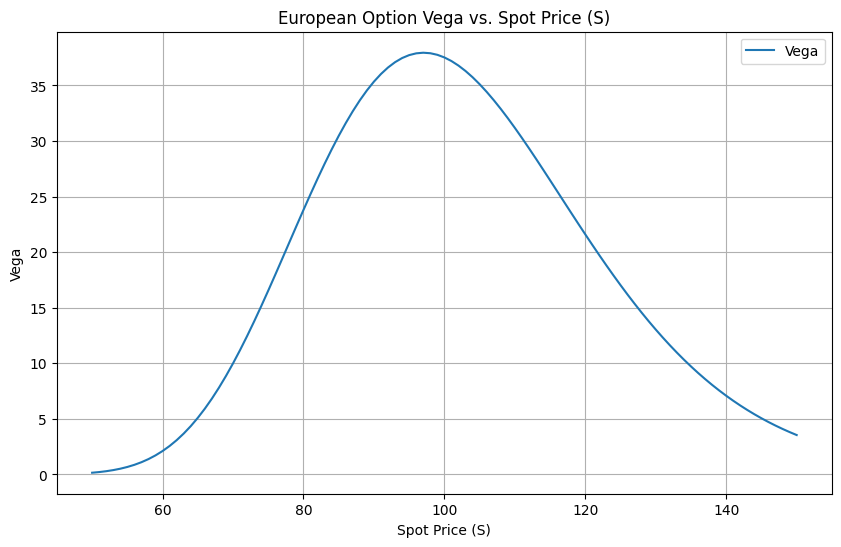

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(vega_df['Spot Price'], vega_df['Vega'], label='Vega')
plt.title('European Option Vega vs. Spot Price (S)')
plt.xlabel('Spot Price (S)')
plt.ylabel('Vega')
plt.grid(True)
plt.legend()
plt.show()

As shown with Gamm one could also numerically approximate Vega and it would also converge to the analytical value. Conclusively, we know that Vega dominates long-dates options and ATM options are volatility sensitive.

<u>**4.3.3. Numerical Validation:**</u>

Numerically $Vega$ can be approximated by:
$Vega = \frac{V(\sigma + h) - V(\sigma - h)}{2h}$

In [44]:
def vega_numerical(S, K, T, r, sigma, h):
  vega_numerical = (black_scholes_price(S, K, T, r, sigma + h) - black_scholes_price(S, K, T, r, sigma - h)) / (2 * h)
  return vega_numerical

In [45]:
S, K, T, r, sigma = 120, 100, 1, 0.05, 0.2
vega_analytical = bs_vega(S, K, T, r, sigma)
print("Analytical Vega = ", vega_analytical)
print("Numerical Vega 1 = ", vega_numerical(S, K, T, r, sigma, 0.1))
print("Numerical Vega 2 = ", vega_numerical(S, K, T, r, sigma, 0.01))
print("Numerical Vega 3 = ", vega_numerical(S, K, T, r, sigma, 0.001))
print("Numerical Vega 4 = ", vega_numerical(S, K, T, r, sigma, 0.0001)) ## Notice convergence of numerical vega towards analytical value

Analytical Vega =  21.600708374990347
Numerical Vega 1 =  19.83435108118684
Numerical Vega 2 =  21.580346705660247
Numerical Vega 3 =  21.60050459322349
Numerical Vega 4 =  21.60070633721034


**<u>4.4. Theta:</u>**
Theta Measures sensitivity of an option price to the passage of time. It essentially describes the time decay of the option price.
Mathematically: $\boxed{\Theta = \frac{\partial V}{\partial T}}$
Usually Theta is negative for calls and puts. AT ATM it decays the fastest and accelerates as maturity approaches.
Traders usually use the following convention: $\boxed{\Theta = - \frac{\partial V}{\partial T}}$, which will also be used in this notebook.
Applying this to the Black-Scholes equations:

$\boxed{\Theta_C = -\frac{Sn(d_1)\sigma}{2\sqrt(T)}-rKe^{-rT}N(d_2)}$ &

$\boxed{\Theta_P = -\frac{Sn(d_1)\sigma}{2\sqrt(T)}-rKe^{-rT}N(-d_2)}$

In [46]:
## Implementin Theta
def bs_theta(S, K, T, r, sigma, optionType = "call"):
  # define normal pdf and cdf:
  n = lambda x: si.norm.pdf(x)
  N = lambda x: si.norm.cdf(x)
  #compute d_1, d_2:
  d_1 = (math.log(S/K) + (r + sigma ** 2 / 2) * T) / (sigma * math.sqrt(T))
  d_2 = d_1 - sigma * math.sqrt(T)
  # compute theta
  if optionType == "call":
    theta_call = -(S * n(d_1) * sigma / (2 * math.sqrt(T))) - r * K * math.exp(-r * T) * N(d_2)
    return theta_call
  else:
    theta_put = -(S * n(d_1) * sigma / (2 * math.sqrt(T))) + r * K * math.exp(-r * T) * N(-d_2) # Corrected sign
    return theta_put

**<u>4.4.1. Testing Theta:</u>**

In [47]:
## ATM
S, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
theta_C_ATM = bs_theta(S, K, T, r, sigma)
theta_P_ATM = bs_theta(S, K, T, r, sigma, optionType = "put")
print("Theta Call ATM = ", theta_C_ATM) # needs to be <0
print("Theta Put ATM = ", theta_P_ATM) # usually < 0

Theta Call ATM =  -6.414027546438197
Theta Put ATM =  -1.657880423934626


In [48]:
## ATM dominance
S_OTM, S_ATM, S_ITM, K, T, r, sigma = 80, 100, 120, 100, 1, 0.05, 0.2
# For Call Options
print("For Call Options: ")
print("Call Theta OTM = ", bs_theta(S_OTM, K, T, r, sigma))
print("Call Theta ATM = ", bs_theta(S_ATM, K, T, r, sigma))
print("Call Theta ITM = ", bs_theta(S_ITM, K, T, r, sigma)) # abs(Theta(100)) > abs(Theta(120)), abs(Theta(80))
print("For Put Options: ")
print("Put Theta OTM = ", bs_theta(S_OTM, K, T, r, sigma, optionType = "put"))
print("Put Theta ATM = ", bs_theta(S_ATM, K, T, r, sigma, optionType = "put"))
print("Put Theta ITM = ", bs_theta(S_ITM, K, T, r, sigma, optionType = "put")) # abs(Theta(100)) > abs(Theta(120)), abs(Theta(80))

For Call Options: 
Call Theta OTM =  -3.1752904259281576
Call Theta ATM =  -6.414027546438197
Call Theta ITM =  -6.2303487786191525
For Put Options: 
Put Theta OTM =  1.5808566965754127
Put Theta ATM =  -1.657880423934626
Put Theta ITM =  -1.4742016561155817


In [49]:
## Time Accelerations
S, K, T_1, T_2, T_3, r, sigma = 120, 100, 1, 0.1, 0.01, 0.05, 0.2
print("For Call Options: ")
print("Call Theta_T1 = ", bs_theta(S, K, T_1, r, sigma))
print("Call Theta_T2 = ", bs_theta(S, K, T_2, r, sigma))
print("Call Theta_T3 = ", bs_theta(S, K, T_3, r, sigma)) # abs(Theta(T_1)) > abs(Theta(T_2)), abs(Theta(T_3))
print("For Put Options: ")
print("Put Theta_T1 = ", bs_theta(S, K, T_1, r, sigma, optionType = "put"))
print("Put Theta_T2 = ", bs_theta(S, K, T_2, r, sigma, optionType = "put"))
print("Put Theta_T3 = ", bs_theta(S, K, T_3, r, sigma, optionType = "put")) # abs(Theta(T_1)) > abs(Theta(T_2)), abs(Theta(T_3))

For Call Options: 
Call Theta_T1 =  -6.2303487786191525
Call Theta_T2 =  -5.138153149499343
Call Theta_T3 =  -4.997500624895847
For Put Options: 
Put Theta_T1 =  -1.4742016561155817
Put Theta_T2 =  -0.16309075353593133
Put Theta_T3 =  -3.114161439187817e-17


**<u>4.4.2. Plotting Theta:</u>**

In [50]:
S_range_theta = np.linspace(50, 150, 101) # Range of spot prices from 50 to 150
K = 100
T = 1.0
r = 0.05
sigma = 0.2

call_thetas = []
put_thetas = []

for S_val in S_range_theta:
    call_theta = bs_theta(S_val, K, T, r, sigma, optionType="call")
    put_theta = bs_theta(S_val, K, T, r, sigma, optionType="put")
    call_thetas.append(call_theta)
    put_thetas.append(put_theta)

theta_df = pd.DataFrame({
    'Spot Price': S_range_theta,
    'Call Theta': call_thetas,
    'Put Theta': put_thetas
})

print("Generated DataFrame for Option Thetas vs Spot Price:")
display(theta_df.head())
display(theta_df.tail())

Generated DataFrame for Option Thetas vs Spot Price:


,Spot Price,Call Theta,Put Theta
0,50.0,-0.017728,4.738419
1,51.0,-0.024577,4.731570
2,52.0,-0.033541,4.722606
3,53.0,-0.045095,4.711052
4,54.0,-0.059776,4.696371


,Spot Price,Call Theta,Put Theta
96,146.0,-5.129937,-0.373789
97,147.0,-5.105701,-0.349554
98,148.0,-5.082783,-0.326635
99,149.0,-5.061135,-0.304988
100,150.0,-5.040711,-0.284564


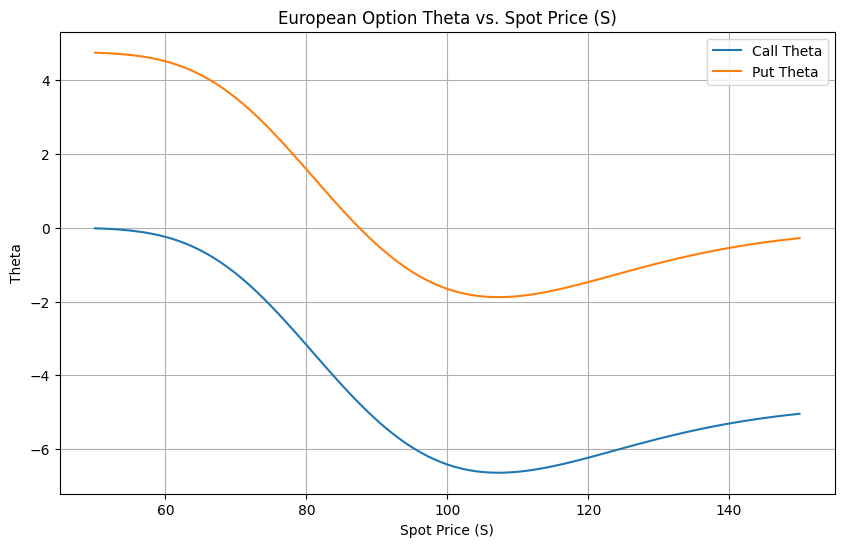

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(theta_df['Spot Price'], theta_df['Call Theta'], label='Call Theta')
plt.plot(theta_df['Spot Price'], theta_df['Put Theta'], label='Put Theta')
plt.title('European Option Theta vs. Spot Price (S)')
plt.xlabel('Spot Price (S)')
plt.ylabel('Theta')
plt.grid(True)
plt.legend()
plt.show()

**<u>4.4.3. Numerical Validation:</u>**

In [52]:
def theta_numerical(S, K, T, r, sigma, h, optionType = "call"):
  if optionType == "call":
    theta_numerical = -(black_scholes_price(S, K, T + h, r, sigma) - black_scholes_price(S, K, T - h, r, sigma)) / (2* h)
    return theta_numerical
  else:
    theta_numerical = -(black_scholes_price(S, K, T + h, r, sigma, "put") - black_scholes_price(S, K, T - h, r, sigma, "put")) / (2* h)
    return theta_numerical

In [53]:
S, K, T, r, sigma = 120, 100, 1, 0.05, 0.2
theta_analytical_C = bs_theta(S, K, T, r, sigma)
theta_analytical_P = bs_theta(S, K, T, r, sigma, optionType = "put")
## For call options
print("For Call Options: ")
print("Analytical Theta = ", theta_analytical_C)
print("Numerical Theta 1 = ", theta_numerical(S, K, T, r, sigma, 1))
print("Numerical Theta 2 = ", theta_numerical(S, K, T, r, sigma, 0.1))
print("Numerical Theta 3 = ", theta_numerical(S, K, T, r, sigma, 0.01))
print("Numerical Theta 4 = ", theta_numerical(S, K, T, r, sigma, 0.001))
## For put options
print("For Put Options: ")
print("Analytical Theta = ", theta_analytical_P)
print("Numerical Theta 1 = ", theta_numerical(S, K, T, r, sigma, 1, "put"))
print("Numerical Theta 2 = ", theta_numerical(S, K, T, r, sigma, 0.1, "put"))
print("Numerical Theta 3 = ", theta_numerical(S, K, T, r, sigma, 0.01, "put"))
print("Numerical Theta 4 = ", theta_numerical(S, K, T, r, sigma, 0.001, "put"))
## Notice convergence to approx value to analytical value

For Call Options: 
Analytical Theta =  -6.2303487786191525
Numerical Theta 1 =  -5.982423625954034
Numerical Theta 2 =  -6.230193332926035
Numerical Theta 3 =  -6.230347340692077
Numerical Theta 4 =  -6.230348764255211
For Put Options: 
Analytical Theta =  -1.4742016561155817
Numerical Theta 1 =  -1.224294527752015
Numerical Theta 2 =  -1.4740263931180575
Numerical Theta 3 =  -1.4742000200152816
Numerical Theta 4 =  -1.4742016397635282


**<u>4.5. Rho:</u>**

Rho measures the sensitivity of the option price to a change in the risk-free interest rate. A positive Rho for a call option means its value increases with higher interest rates, while a negative Rho for a put option means its value decreases with higher interest rates.

Mathematically: $\boxed{\rho = \frac{\partial V}{\partial r}}$

Applying this to the Black-Scholes equations:

$\boxed{\rho_C = K T e^{-rT} N(d_2)}$

$\boxed{\rho_P = -K T e^{-rT} N(-d_2)}$

In [54]:
## Implementing Rho
def bs_rho(S, K, T, r, sigma, optionType = "call"):
  # Define normal CDF:
  N = lambda x: si.norm.cdf(x)
  # Compute d_1, d_2:
  d_1 = (math.log(S/K) + (r + sigma ** 2 / 2) * T) / (sigma * math.sqrt(T))
  d_2 = d_1 - sigma * math.sqrt(T)

  # Compute Rho for options:
  if optionType == "call":
    rho_call = K * T * math.exp(-r * T) * N(d_2)
    return rho_call
  else:
    rho_put = -K * T * math.exp(-r * T) * N(-d_2)
    return rho_put

**<u>4.5.1. Testing Rho:</u>**

In [55]:
## Test with typical values
S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
rho_C_test = bs_rho(S, K, T, r, sigma)
rho_P_test = bs_rho(S, K, T, r, sigma, optionType = "put")
print("Rho Call = ", rho_C_test)
print("Rho Put = ", rho_P_test)

## ATM
S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
rho_C_atm = bs_rho(S, K, T, r, sigma)
rho_P_atm = bs_rho(S, K, T, r, sigma, optionType = "put")
print("Rho Call ATM = ", rho_C_atm)
print("Rho Put ATM = ", rho_P_atm)

## ITM Call / OTM Put
S, K, T, r, sigma = 120, 100, 1.0, 0.05, 0.2
rho_C_itm = bs_rho(S, K, T, r, sigma)
rho_P_otm = bs_rho(S, K, T, r, sigma, optionType = "put")
print("Rho Call ITM = ", rho_C_itm)
print("Rho Put OTM = ", rho_P_otm)

## OTM Call / ITM Put
S, K, T, r, sigma = 80, 100, 1.0, 0.05, 0.2
rho_C_otm = bs_rho(S, K, T, r, sigma)
rho_P_itm = bs_rho(S, K, T, r, sigma, optionType = "put")
print("Rho Call OTM = ", rho_C_otm)
print("Rho Put ITM = ", rho_P_itm)

Rho Call =  53.232481545376345
Rho Put =  -41.89046090469506
Rho Call ATM =  53.232481545376345
Rho Put ATM =  -41.89046090469506
Rho Call ITM =  81.40555882240236
Rho Put OTM =  -13.717383627669058
Rho Call OTM =  15.894350799042194
Rho Put ITM =  -79.22859165102922


**<u>4.5.2. Plotting Rho:</u>**

In [56]:
S_range_rho = np.linspace(50, 150, 101) # Range of spot prices from 50 to 150
K = 100
T = 1.0
r = 0.05
sigma = 0.2

call_rhos = []
put_rhos = []

for S_val in S_range_rho:
    call_rho = bs_rho(S_val, K, T, r, sigma, optionType="call")
    put_rho = bs_rho(S_val, K, T, r, sigma, optionType="put")
    call_rhos.append(call_rho)
    put_rhos.append(put_rho)

rho_df = pd.DataFrame({
    'Spot Price': S_range_rho,
    'Call Rho': call_rhos,
    'Put Rho': put_rhos
})

print("Generated DataFrame for Option Rhos vs Spot Price:")
display(rho_df.head())
display(rho_df.tail())

Generated DataFrame for Option Rhos vs Spot Price:


,Spot Price,Call Rho,Put Rho
0,50.0,0.043472,-95.079470
1,51.0,0.061670,-95.061272
2,52.0,0.086123,-95.036820
3,53.0,0.118492,-95.004451
4,54.0,0.160733,-94.962209


,Spot Price,Call Rho,Put Rho
96,146.0,93.166574,-1.956368
97,147.0,93.322022,-1.800920
98,148.0,93.465890,-1.657053
99,149.0,93.598956,-1.523986
100,150.0,93.721958,-1.400984


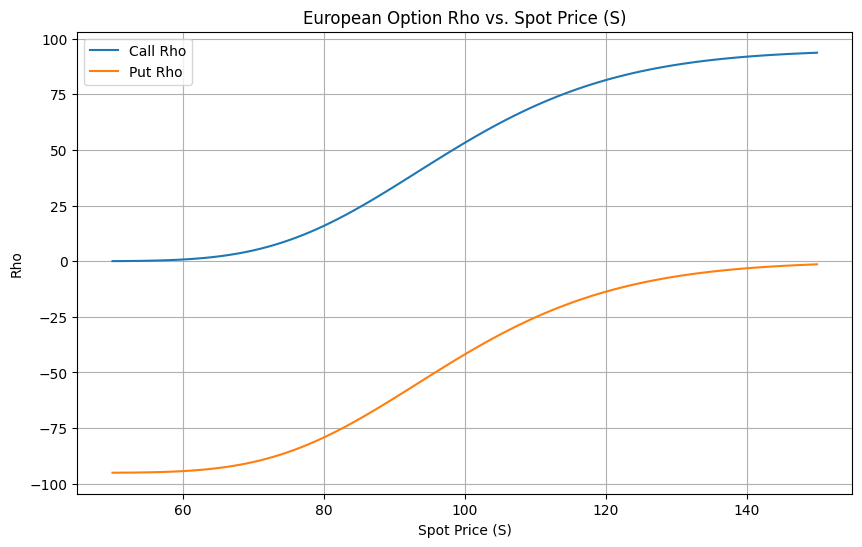

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(rho_df['Spot Price'], rho_df['Call Rho'], label='Call Rho')
plt.plot(rho_df['Spot Price'], rho_df['Put Rho'], label='Put Rho')
plt.title('European Option Rho vs. Spot Price (S)')
plt.xlabel('Spot Price (S)')
plt.ylabel('Rho')
plt.grid(True)
plt.legend()
plt.show()

<u>**4.5.3. Numerical Validation:**</u>

Numerically $\rho$ can be approximated by:
$\rho = \frac{V(r + h) - V(r - h)}{2h}$

In [58]:
def rho_numerical(S, K, T, r, sigma, h, optionType = "call"):
  if optionType == "call":
    rho_numerical_val = (black_scholes_price(S, K, T, r + h, sigma) - black_scholes_price(S, K, T, r - h, sigma)) / (2* h)
    return rho_numerical_val
  else:
    rho_numerical_val = (black_scholes_price(S, K, T, r + h, sigma, "put") - black_scholes_price(S, K, T, r - h, sigma, "put")) / (2* h)
    return rho_numerical_val

In [59]:
S, K, T, r, sigma = 120, 100, 1, 0.05, 0.2
rho_analytical_C = bs_rho(S, K, T, r, sigma)
rho_analytical_P = bs_rho(S, K, T, r, sigma, optionType = "put")
## For call options
print("For Call Options: ")
print("Analytical Rho = ", rho_analytical_C)
print("Numerical Rho 1 = ", rho_numerical(S, K, T, r, sigma, 0.1))
print("Numerical Rho 2 = ", rho_numerical(S, K, T, r, sigma, 0.01))
print("Numerical Rho 3 = ", rho_numerical(S, K, T, r, sigma, 0.001))
print("Numerical Rho 4 = ", rho_numerical(S, K, T, r, sigma, 0.0001))
## For put options
print("For Put Options: ")
print("Analytical Rho = ", rho_analytical_P)
print("Numerical Rho 1 = ", rho_numerical(S, K, T, r, sigma, 0.1, "put"))
print("Numerical Rho 2 = ", rho_numerical(S, K, T, r, sigma, 0.01, "put"))
print("Numerical Rho 3 = ", rho_numerical(S, K, T, r, sigma, 0.001, "put"))
print("Numerical Rho 4 = ", rho_numerical(S, K, T, r, sigma, 0.0001, "put"))
## Notice convergence to approx value to analytical value

For Call Options: 
Analytical Rho =  81.40555882240236
Numerical Rho 1 =  80.24372967181726
Numerical Rho 2 =  81.39376248700358
Numerical Rho 3 =  81.4054408411522
Numerical Rho 4 =  81.40555764263979
For Put Options: 
Analytical Rho =  -13.717383627669058
Numerical Rho 1 =  -15.037830303665855
Numerical Rho 2 =  -13.730765353367769
Numerical Rho 3 =  -13.717517462738194
Numerical Rho 4 =  -13.717384966005497


# **5. Monte Carlo Pricing**

Monte Carlo Simoulations are a numerical method, which can be used in Options Pricing contrary to the analytical Black-Scholes Pricing model. While Monte Carlo Methods are slower, they are applied when no closed form solutions exist. In this section Monte Carlo Methods will be used to validate the results against the Black Scholes Formula.

<u> Underlying Stochastic Model:</u>
The Price of the underlying asset follows a geometric Brownian Motion, which is described by the stochastic differential equation:
$ dS = \mu Sdt + σSdW$ where $W$ describes the standard Brownian Motion.
This stochastic differential equation offers the following solution for the terminal price $S_T$:

$S_T = S_0exp[(r - \frac{1}{2}\sigma^2)T + \sigma\sqrt(T)Z]$, where $Z ∝ N(\mu = 0, \sigma = 1)$

<u>The Monte Carlo Pricing Algorithm:</u>


*   Sample n independent standard normal random variables
*   Compute $S_T$ using exact solution
*   Compute Option Payoffs:
        Call: $max(S_T-K, 0)$, Put: $max(K - S_T, 0)$

*   Discount the average payoff back to time 0:
$V_0 = e^{-rT}𝔼[payoff]$






In [78]:
## Implementing Monte Carlo Pricing
def monte_carlo_price(S, K, T, r, sigma, optionType = "call", num_simulations = 10000, random_numbers=None):
  # Generate random numbers if not provided (for CRN technique)
  if random_numbers is None:
      Z = np.random.standard_normal(size = num_simulations)
  else:
      Z = random_numbers

  #Compute S_T:
  S_T = S * np.exp((r - 0.5 * sigma ** 2) * T + sigma * math.sqrt(T) * Z)
  # Compute payoff:
  if optionType == "call":
    payoff = np.maximum(S_T - K, 0)
  else:
    payoff = np.maximum(K - S_T, 0)
  # Discount the average
  price = math.exp(-r * T) * np.mean(payoff)
  return price

**<u>5.1. MC - BS Comparison:</u>**

In [71]:
S, K, T, r, sigma = 120, 100, 1, 0.05, 0.2
## Black Scholes Prices
bs_call = black_scholes_price(S, K, T, r, sigma)
bs_put = black_scholes_price(S, K, T, r, sigma, optionType = "put")

print(f"Black-Scholes Call Price: {bs_call:.4f}")
print(f"Black-Scholes Put Price: {bs_put:.4f}")

## Monte Carlo Prices
num_simulations_list = [1000, 10000, 100000, 1000000]
print("\nMonte Carlo Prices:")
for num_simulations in num_simulations_list:
  mc_call = monte_carlo_price(S, K, T, r, sigma, optionType = "call", num_simulations = num_simulations)
  mc_put = monte_carlo_price(S, K, T, r, sigma, optionType = "put", num_simulations = num_simulations)
  print(f"  Simulations: {num_simulations:7d} | MC Call: {mc_call:.4f} | MC Put: {mc_put:.4f}")

Black-Scholes Call Price: 26.1690
Black-Scholes Put Price: 1.2920

Monte Carlo Prices:
  Simulations:    1000 | MC Call: 27.0228 | MC Put: 1.2126
  Simulations:   10000 | MC Call: 25.8090 | MC Put: 1.3366
  Simulations:  100000 | MC Call: 26.1775 | MC Put: 1.2947
  Simulations: 1000000 | MC Call: 26.1736 | MC Put: 1.2901


**<u>5.2. Convergence Visualization:</u>**

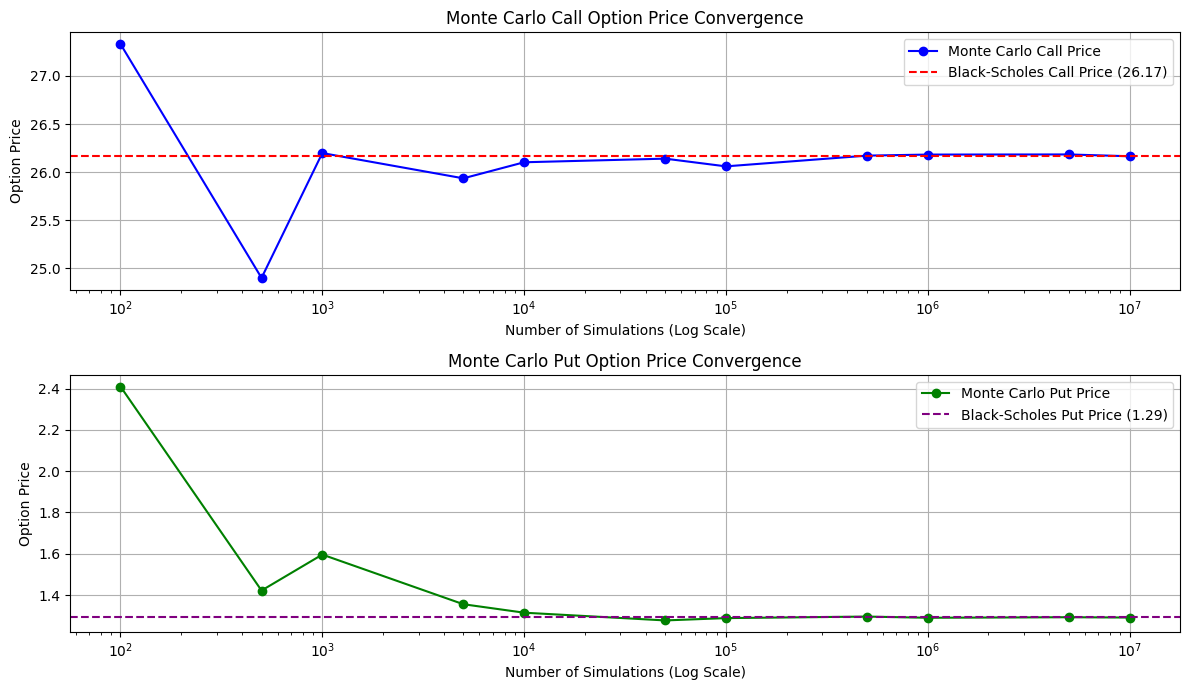

In [73]:
# Parameters (same as used for the comparison)
S, K, T, r, sigma = 120, 100, 1, 0.05, 0.2

# Black-Scholes prices (already calculated in howSa5PiKIRy)
bs_call = black_scholes_price(S, K, T, r, sigma)
bs_put = black_scholes_price(S, K, T, r, sigma, optionType = "put")

# Monte Carlo prices for different number of simulations
# Increased span for num_simulations_list to better visualize convergence
num_simulations_list = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]

mc_call_prices = []
mc_put_prices = []

for num_simulations in num_simulations_list:
    mc_call = monte_carlo_price(S, K, T, r, sigma, optionType="call", num_simulations=num_simulations)
    mc_put = monte_carlo_price(S, K, T, r, sigma, optionType="put", num_simulations=num_simulations)
    mc_call_prices.append(mc_call)
    mc_put_prices.append(mc_put)

# Create the plot
plt.figure(figsize=(12, 7))

# Plot Call Option Convergence
plt.subplot(2, 1, 1) # 2 rows, 1 column, 1st plot
plt.plot(num_simulations_list, mc_call_prices, '-o', label='Monte Carlo Call Price', color='blue')
plt.axhline(y=bs_call, color='red', linestyle='--', label=f'Black-Scholes Call Price ({bs_call:.2f})')
plt.xscale('log')
plt.title('Monte Carlo Call Option Price Convergence')
plt.xlabel('Number of Simulations (Log Scale)')
plt.ylabel('Option Price')
plt.grid(True)
plt.legend()

# Plot Put Option Convergence
plt.subplot(2, 1, 2) # 2 rows, 1 column, 2nd plot
plt.plot(num_simulations_list, mc_put_prices, '-o', label='Monte Carlo Put Price', color='green')
plt.axhline(y=bs_put, color='purple', linestyle='--', label=f'Black-Scholes Put Price ({bs_put:.2f})')
plt.xscale('log')
plt.title('Monte Carlo Put Option Price Convergence')
plt.xlabel('Number of Simulations (Log Scale)')
plt.ylabel('Option Price')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**<u>5.3. Conclusion:</u>**
Monte Carlo estimates exhibit statistical errors due to finite sampling. The pricing error reduces with increasing number of simulations. This is consistent with the theoretical convergence rate of Monte Carlo methods.

While Black Scholes is computationally instantaneous, Monte Carlo Pricing is much slower but much more flexible. This highlights the tradeoffs between analytical effeciency and numerical generality.

In this notebook the Monte Carlo simulation successfully reproduces Black-Scholes prices for European options. Accuracy expectedly improves with the number of simulations, coming at the cost of increased computation time. While this is a bit unnecessary for simple European options, Monte Carlo Methods can be very useful for pricing more complex financial assets.

# **6. Monte Carlo Greeks**
Analytic Greeks are not always available, thus also Greeks can be numerically approximated after computing the Monte Carlo prices. In this section delta and Vega will be implemented as examples


**<u>6.1. MC-Delta:</u>**

$\delta = \frac{\partial V}{\partial S_0} ≈ \frac{V(S + h) - V(S - h)}{2h}$

In [79]:
def mc_delta(S, K, T, r, sigma, h, optionType = "call", num_simulations= 1000000):
  # Generate random numbers once for both paths (Common Random Numbers technique)
  Z = np.random.standard_normal(size = num_simulations)

  price_plus_h = monte_carlo_price(S + h, K, T, r, sigma, optionType = optionType, num_simulations = num_simulations, random_numbers=Z)
  price_minus_h = monte_carlo_price(S - h, K, T, r, sigma, optionType = optionType, num_simulations = num_simulations, random_numbers=Z)

  delta_mc = (price_plus_h - price_minus_h) / (2 * h)
  return delta_mc

In [81]:
S, K, T, r, sigma = 120, 100, 1, 0.05, 0.2
print("BS Delta = ", bs_delta(S, K, T, r, sigma))
print("MC Delta 1 = ", mc_delta(S, K, T, r, sigma, 1))
print("MC Delta 2 = ", mc_delta(S, K, T, r, sigma, 0.1))
print("MC Delta 3 = ", mc_delta(S, K, T, r, sigma, 0.01))
print("MC Delta 4 = ", mc_delta(S, K, T, r, sigma, 0.001))

BS Delta =  0.8964550230770805
MC Delta 1 =  0.8964070983632872
MC Delta 2 =  0.8960543221809125
MC Delta 3 =  0.8970690520104796
MC Delta 4 =  0.8966239238343832


**<u>6.2. MC-Vega:</u>**

$Vega = \frac{\partial V}{\partial \sigma} \approx \frac{V(\sigma + h) - V(\sigma - h)}{2h}$

In [82]:
def mc_vega(S, K, T, r, sigma, h, optionType = "call", num_simulations= 1000000):
  # Generate random numbers once for both paths (Common Random Numbers technique)
  Z = np.random.standard_normal(size = num_simulations)

  price_plus_h = monte_carlo_price(S, K, T, r, sigma + h, optionType = optionType, num_simulations = num_simulations, random_numbers=Z)
  price_minus_h = monte_carlo_price(S, K, T, r, sigma - h, optionType = optionType, num_simulations = num_simulations, random_numbers=Z)

  vega_mc = (price_plus_h - price_minus_h) / (2 * h)
  return vega_mc

In [83]:
S, K, T, r, sigma = 120, 100, 1, 0.05, 0.2
print("BS Vega = ", bs_vega(S, K, T, r, sigma))
print("MC Vega 1 = ", mc_vega(S, K, T, r, sigma, 0.1))
print("MC Vega 2 = ", mc_vega(S, K, T, r, sigma, 0.01))
print("MC Vega 3 = ", mc_vega(S, K, T, r, sigma, 0.001))
print("MC Vega 4 = ", mc_vega(S, K, T, r, sigma, 0.0001))

BS Vega =  21.600708374990347
MC Vega 1 =  19.839107123610624
MC Vega 2 =  21.666107688182024
MC Vega 3 =  21.69458011531944
MC Vega 4 =  21.46089842508303


# **7. Variance Reduction in Monte Carlo Pricing**
Monte Carlo pricing converges at a slow rate of 𝒪(1/√N), meaning that high accuracy
requires a very large number of simulated paths.

Variance reduction techniques aim to improve estimator accuracy without increasing
the number of simulations, thereby reducing computational cost.

In this section, we implement and evaluate two widely used variance reduction methods:

• Antithetic Variates  
• Control Variates (using the Black–Scholes price)

Both methods preserve unbiasedness while significantly reducing estimator variance.


**<u> 7.1. Antithetic Variates:</u>**

Antithetic variates exploit symmetry in the normal distribution.

For every random draw Z ~ 𝒩(0, 1), we also simulate −Z.
The resulting terminal prices are negatively correlated.

By averaging the payoffs of these paired paths, variance is reduced at
almost no additional computational cost.


In [84]:
def monte_carlo_antithetic(
    S, K, T, r, sigma,
    optionType="call",
    n_paths=100_000,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    n_half = n_paths // 2
    Z = np.random.standard_normal(n_half)
    Z_antithetic = -Z

    Z_full = np.concatenate([Z, Z_antithetic])

    S_T = S * np.exp(
        (r - 0.5 * sigma**2) * T
        + sigma * np.sqrt(T) * Z_full
    )

    if optionType == "call":
        payoffs = np.maximum(S_T - K, 0.0)
    else:
        payoffs = np.maximum(K - S_T, 0.0)

    price = np.exp(-r * T) * np.mean(payoffs)
    std = np.std(payoffs, ddof=1)

    return price, std

In [86]:
## Comparison
mc_price, mc_std = monte_carlo_price(
    S, K, T, r, sigma,
    optionType="call",
    num_simulations=200_000
), None

anti_price, anti_std = monte_carlo_antithetic(
    S, K, T, r, sigma,
    optionType="call",
    n_paths=200_000,
    seed=42
)
print(f"Monte Carlo Price: {mc_price:.4f}")
print(f"Antithetic Variates Price: {anti_price:.4f}")

Monte Carlo Price: 26.1494
Antithetic Variates Price: 26.1764


**<u> 7.2. Control Variates: </u>**
Control variates reduce variance by exploiting correlation with a variable
whose expected value is known analytically.

Here, the Black–Scholes price serves as an ideal control variate because:

• It is highly correlated with Monte Carlo payoffs  
• Its exact value is known  

This allows us to adjust the Monte Carlo estimator to reduce variance
without introducing bias.


In [87]:
def monte_carlo_control_variate(
    S, K, T, r, sigma,
    optionType="call",
    n_paths=100_000,
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    Z = np.random.standard_normal(n_paths)

    S_T = S * np.exp(
        (r - 0.5 * sigma**2) * T
        + sigma * np.sqrt(T) * Z
    )

    if optionType == "call":
        payoffs = np.maximum(S_T - K, 0.0)
    else:
        payoffs = np.maximum(K - S_T, 0.0)

    discounted_payoffs = np.exp(-r * T) * payoffs

    # Control variate: Black–Scholes price
    bs_price = black_scholes_price(S, K, T, r, sigma, optionType)

    cov = np.cov(discounted_payoffs, discounted_payoffs)[0, 1]
    var = np.var(discounted_payoffs)

    beta = cov / var

    adjusted_estimator = (
        discounted_payoffs
        + beta * (bs_price - np.mean(discounted_payoffs))
    )

    return np.mean(adjusted_estimator), np.std(adjusted_estimator, ddof=1)

In [89]:
## Comparison
standard_price = monte_carlo_price(
    S, K, T, r, sigma,
    optionType="call",
    num_simulations=200_000
)

anti_price, anti_std = monte_carlo_antithetic(
    S, K, T, r, sigma,
    optionType="call",
    n_paths=200_000,
    seed=42
)

cv_price, cv_std = monte_carlo_control_variate(
    S, K, T, r, sigma,
    optionType="call",
    n_paths=200_000,
    seed=42
)

print("Standard Monte Carlo Price = ", standard_price)
print("Antithetic Variates Price = ", anti_price)
print("Control Variates Price = ", cv_price)

Standard Monte Carlo Price =  26.15329688101043
Antithetic Variates Price =  26.17637701242219
Control Variates Price =  26.16904384187155


The results demonstrate that variance reduction techniques significantly
improve Monte Carlo efficiency.

Antithetic variates reduce variance at negligible computational cost and are
easy to implement, making them attractive in practice.

Control variates achieve the largest variance reduction by leveraging
analytical pricing formulas, but require additional computations and
model assumptions.

In production environments, the choice of technique depends on the tradeoff
between simplicity, robustness, and performance.
